***Final Project***

***Step 1: Model Training***

In [1]:
!mkdir train
# Put the cat training set into the directory
!unzip /airplane.zip -d /train
# Put the deer training set into the directory
!unzip /car.zip -d /train
# Put the bird training set into the directory
!unzip /truck.zip -d /train

Streaming output truncated to the last 5000 lines.
  inflating: /train/truck/img10149.png  
  inflating: /train/truck/img10219.png  
  inflating: /train/truck/img10257.png  
  inflating: /train/truck/img10306.png  
  inflating: /train/truck/img10351.png  
  inflating: /train/truck/img10388.png  
  inflating: /train/truck/img10523.png  
  inflating: /train/truck/img10533.png  
  inflating: /train/truck/img10626.png  
  inflating: /train/truck/img10658.png  
  inflating: /train/truck/img10659.png  
  inflating: /train/truck/img10743.png  
  inflating: /train/truck/img1075.png  
  inflating: /train/truck/img10781.png  
  inflating: /train/truck/img10806.png  
  inflating: /train/truck/img10853.png  
  inflating: /train/truck/img10934.png  
  inflating: /train/truck/img10972.png  
  inflating: /train/truck/img1102.png  
  inflating: /train/truck/img11104.png  
  inflating: /train/truck/img11152.png  
  inflating: /train/truck/img11170.png  
  inflating: /train/truck/img11173.png  
  inflat

In [2]:
#import required libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# import to_categorical from tensorflow
from tensorflow.keras.utils import to_categorical
# save each epoch of the model
from keras.callbacks import ModelCheckpoint

# Load the images from the directory
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            images.append(img)
    return images

# The folder paths your images are located in.  You will change these for your directories.
folder_paths = ['/train/airplane', '/train/car', '/train/truck']

# The class names/labels of your images.
class_labels = {'airplane': 0, 'car': 1, 'truck': 2}

# The lists to store your images and labels in.
x_train = []
y_train = []

# Load the images and labels into the lists.
for folder_path in folder_paths:
    class_name = os.path.basename(folder_path)
    class_id = class_labels[class_name]
    images = load_images_from_folder(folder_path)

    # Extend the lists to add the images and labels from the loaded folder.
    x_train.extend(images)
    y_train.extend([class_id] * len(images))

# Convert the loaded lists into numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
# Print the shape of the training data
#print(f"x_train shape: {x_train.shape}")
#print(f"y_train shape: {y_train.shape}")

# Print the first 10 labels
#print(f"Sample labels: {y_train[:10]}")
# Show an image in the training set. Change the index to view different images.
#plt.imshow(x_train[5000])
#print(y_train[6000])
## !!!! There's is a bug in this step, the model is not training with normalized data!!!
# Normalize the training data
#x_train = x_train.astype('float32') / 255.0


train_ds = keras.utils.image_dataset_from_directory(
 directory='/train',
 labels='inferred',
 label_mode='categorical',
 batch_size=32,
 image_size=(64, 64))

# Create a base model of VGG16
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(64, 64, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Add the base model to a sequential model
model = keras.Sequential([
    base_model,  # Add the VGG16 base model
    keras.layers.Flatten(),  # Convert 3D features to 1D feature vectors
    keras.layers.Dense(3, activation='softmax')  # Add the softmax layer
])

checkpoint_path = "best_model.tf"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

# Define the VGG16 architecture
model = keras.Sequential([

    # Normalize the images to pixel values (0, 1)
    # keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64,64,3)),

    # Add data augmentation here
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(64,64,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),

    # Block 1
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    # Block 2
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    # Block 3
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    # Block 4
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    # Block 5
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    # Fully connected layers
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.3),
    Dense(2048, activation='relu'),
    Dense(3, activation='softmax')
])

# Fine tune the sgd optimizer
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Compile the model
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=80, batch_size=32, shuffle=True, validation_split=0.2, callbacks=[checkpoint])


Found 15000 files belonging to 3 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/80
375/375 [==============================] - ETA: 0s - loss: 1.0093 - accuracy: 0.4741
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.tf
375/375 [==============================] - 39s 68ms/step - loss: 1.0093 - accuracy: 0.4741 - val_loss: 2.0121 - val_accuracy: 0.0000e+00
Epoch 2/80
375/375 [==============================] - ETA: 0s - loss: 0.8671 - accuracy: 0.6127
Epoch 2: val_accuracy did not improve from 0.00000
375/375 [==============================] - 22s 59ms/step - loss: 0.8671 - accuracy: 0.6127 - val_loss: 1.5390 - val_accuracy: 0.0000e+00
Epoch 3/80
375/375 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.6999
Epoch 3: val_accuracy improved from 0.00000 to 0.23200, saving model to best_model.tf
375/375 [==============================] - 26s 70ms/step - loss: 0.7123 - accuracy: 0.6999 - val_loss: 1.3752 -

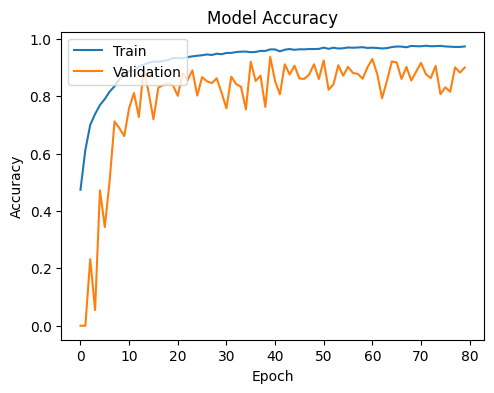

In [3]:
# Ploting graph to show Accuracy between train and validation data
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [4]:
# Saving the data and downloding the best_model
model.save("airplane_car_truck.keras")
!zip -r best_model.zip best_model.tf/
from google.colab import files
files.download("best_model.zip")

  adding: best_model.tf/ (stored 0%)
  adding: best_model.tf/assets/ (stored 0%)
  adding: best_model.tf/saved_model.pb (deflated 89%)
  adding: best_model.tf/fingerprint.pb (stored 0%)
  adding: best_model.tf/variables/ (stored 0%)
  adding: best_model.tf/variables/variables.index (deflated 69%)
  adding: best_model.tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: best_model.tf/keras_metadata.pb (deflated 95%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# Unzip the best_model
!unzip /best_model.zip -d /train

Archive:  /best_model.zip
   creating: /train/best_model.tf/
   creating: /train/best_model.tf/assets/
  inflating: /train/best_model.tf/saved_model.pb  
 extracting: /train/best_model.tf/fingerprint.pb  
   creating: /train/best_model.tf/variables/
  inflating: /train/best_model.tf/variables/variables.index  
  inflating: /train/best_model.tf/variables/variables.data-00000-of-00001  
  inflating: /train/best_model.tf/keras_metadata.pb  


***Step 2: Model Evaluation***

In [6]:
# Loading the model
model_loaded = tf.keras.models.load_model('best_model.tf')
#Evaluating the model
model_loaded.evaluate(x_train,y_train)

469/469 [==============================] - 7s 15ms/step - loss: 0.1162 - accuracy: 0.9577


[0.11618038266897202, 0.9577333331108093]

In [11]:
# Testing the data
y_train[10001]

2

***Step 3: Object Detection and Classification***



*   Loaded the image and trained model.
*   Defined the labels for different classes.

*   Removed the noise by masking the area that is not required in image.
*   Applied the Sobel filter for edge detection.

*   Calculated the magnitude of the gradient
*   Normalized the magnitude to 8-bit for visualization.

*   Threshold the magnitude to get binary edges and find contours.
*   Defining the minimum width and height of object in the image and based on the values i extract the object from the bounding box.

*   Preprocessed the object image for classification
*   Based on the results, I created the rectangle and displays the classification label of the object contained within each box.













1/1 [==============================] - 0s 18ms/step


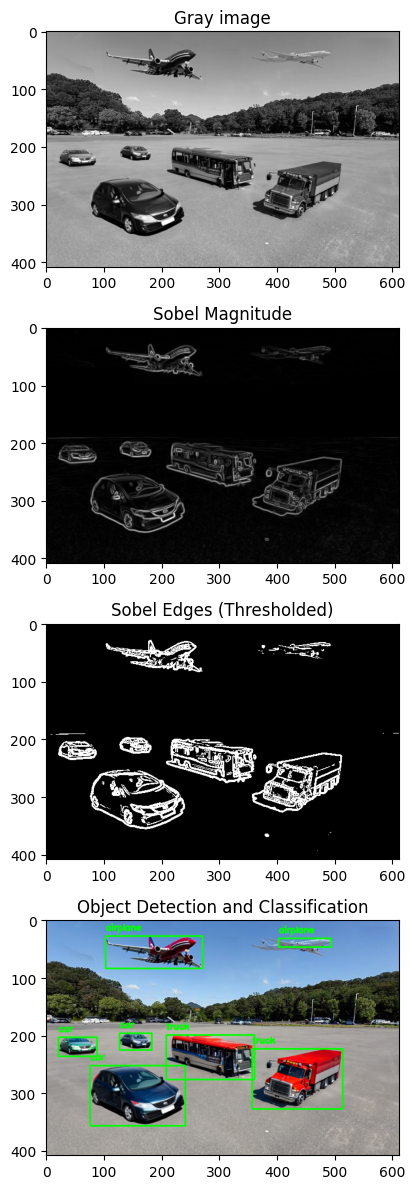

In [16]:
#import required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

def object_detection_and_classification(image_path, model, class_labels):
    # Load the image
    img = cv2.imread(image_path)

    # Define area for the trees in background in order to avoid the noise
    areas_to_remove = [
        (500, 80, 620, 190),
        (150, 100, 500, 190),
        (0, 70, 150, 190)
    ]

    # Create a mask for each area
    mask = np.zeros_like(img[:, :, 0])
    for area in areas_to_remove:
        mask[area[1]:area[3], area[0]:area[2]] = 255

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Sobel filter for edge detection
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate the magnitude of the gradient
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalize the magnitude to 8-bit for visualization
    magnitude = np.uint8(255 * magnitude / np.max(magnitude))

    # Set pixels in the masked areas to zero in the magnitude result
    for area in areas_to_remove:
        magnitude[area[1]:area[3], area[0]:area[2]] = 0

    # Threshold the magnitude to get binary edges
    _, edges_sobel = cv2.threshold(magnitude, 30, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, hierarchy = cv2.findContours(edges_sobel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw only the outer bounding rectangles with a specified size filter
    img_with_rectangles = img.copy()
    # Defining the minimum width and height of object in the image
    min_width = 40
    min_height = 13
    for i in range(len(contours)):
        if hierarchy[0][i][3] == -1:  # Check if the contour has no parent (outermost)
            x, y, w, h = cv2.boundingRect(contours[i])
            if w > min_width and h > min_height:
                # Extract the object from the bounding box
                object_img = img[y:y+h, x:x+w]

                # Preprocess the object image for classification
                object_img_resized = cv2.resize(object_img, (64, 64))  # Adjust size based on your model's input size
                object_img_resized = np.expand_dims(object_img_resized, axis=0)
                #object_img_resized = object_img_resized / 255.0  # Normalize pixel values

                # Perform classification using the model
                predictions = model.predict(object_img_resized)
                #print(predictions)
                # Get the predicted class label
                predicted_class = class_labels[np.argmax(predictions)]
                #print(predicted_class)

                # Draw rectangle and display the class label
                cv2.rectangle(img_with_rectangles, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(img_with_rectangles, predicted_class, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the result with vertically stacked subplots
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 12))
    axes[0].imshow(gray_img, cmap='gray')
    axes[0].set_title('Gray image')

    # Plot individual edges from Sobel filter
    axes[1].imshow(magnitude, cmap='gray')
    axes[1].set_title('Sobel Magnitude')

    axes[2].imshow(edges_sobel, cmap='gray')
    axes[2].set_title('Sobel Edges (Thresholded)')

     # Plot the original image with rectangles
    axes[3].imshow(cv2.cvtColor(img_with_rectangles, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Object Detection and Classification')


    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the result
    plt.show()

# Example usage
image_path = '/car_truck_airplane.jpg'
model = keras.models.load_model('/train/best_model.tf')
class_labels = ["airplane", "car", "truck"]  # Replace with your actual class labels
object_detection_and_classification(image_path, model, class_labels)
